# ToDo

- Create environment variable for data.

#### We need a handful of plots to start defining the pilot sample: ####
- ra vs dec for full redmapper catalog and trimmed catalog
- richness vs redshift for trimmed catalog for spectroscopic clusters only
- think of other plots to make that will help us define a "pilot" sample (e.g., using imag, size, redshift, richness, etc.)
- look at decam_galdepth[2] and/or decam_nobs[2] to find clusters with deeper-than average depth or coverage

### What do we have ###

* SDSS/DR8 redmapper cluster catalog (N~400,000 central galaxies) -- redmapper_isedfit_v5.10_centrals.fits
* redmapper catalog matched to DECaLS/DR3 (N~250,000 matches) -- tractor-redmapper_isedfit_v5.10_centrals.fits

### Convenient References
* [DECaLS Documentation](http://legacysurvey.org/)
* [GitHub Repository](https://github.com/moustakas/siena-astrophysics)
* [Markdown Quick Reference Guide](https://en.support.wordpress.com/markdown-quick-reference)
* [FITS Documentation](http://docs.astropy.org/en/stable/io/fits/#)

In [35]:
import os
import warnings

from astropy.io import fits
import numpy as np
import mpl_toolkits
import matplotlib.pyplot as plt

import seaborn as sns
import fitsio
from desitarget.targetmask import desi_mask, bgs_mask
from desiutil.plots import init_sky, plot_healpix_map, plot_grid_map, plot_sky_circles, plot_sky_binned, prepare_data

%matplotlib inline

### Define the operations to be performed in the subsequent cells.

In [13]:
# Trims data; outputs trimmed data into a fits file
CUTS = True
QAPLOTS = True

### Specify the path and the file.

In [19]:
path = '/Users/kevinnapier/research/dmhalos/'
file = 'tractor-redmapper_isedfit_v5.10_centrals.fits' # dr3data; which one should I use?
centrals = 'redmapper_isedfit_v5.10_centrals.fits' 

In [20]:
data = fits.getdata(os.path.join(path, file))
centralsdata = fits.getdata(os.path.join(path, centrals))

In [25]:
if CUTS == True:
    cuts = np.where(data['OBJID'] == -1)
    newdata = np.delete(centralsdata, cuts[0])
    fits.writeto(os.path.join(path,'tractor_matched_centrals.fits'), newdata, overwrite=True)

In [39]:
guts = os.path.join(path, 'tractor_matched_centrals.fits')
matched = fitsio.read(os.path.join(path, 'tractor_matched_centrals.fits'))
#ii=fitsio.FITS(os.path.join(path, guts))
#print(ii[1])

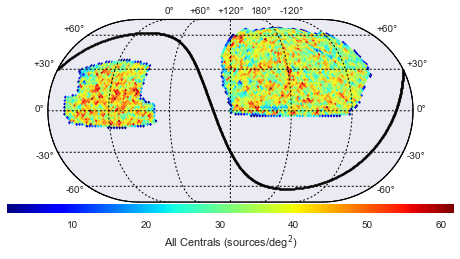

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.figure(figsize=(8,4))
    basemap = init_sky(galactic_plane_color='k');
    plot_sky_binned(centralsdata['RA'], centralsdata['DEC'], verbose=False, clip_lo='!1', plot_type='healpix', 
                    cmap='jet', label=r'All Centrals (sources/deg$^2$)', basemap=basemap);

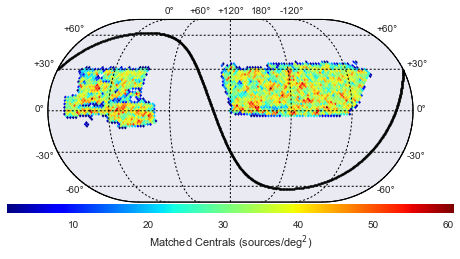

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.figure(figsize=(8,4))
    basemap = init_sky(galactic_plane_color='k');
    plot_sky_binned(matched['RA'], matched['DEC'], verbose=False, clip_lo='!1', plot_type='healpix', cmap='jet', 
                label=r'Matched Centrals (sources/deg$^2$)', basemap=basemap);

In [29]:
REDSHIFT = matched['Z']
RICHNESS = matched['LAMBDA_CHISQ']
IMAG = matched['IMAG']

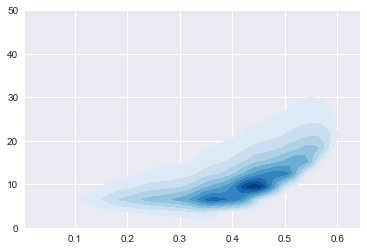

In [40]:
sns.kdeplot(np.array(REDSHIFT), np.array(RICHNESS),cmap="Blues", shade=True, shade_lowest=False)
plt.ylim([0, 50])
plt.show()

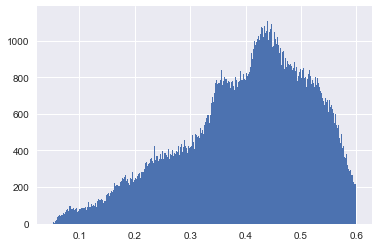

In [42]:
plt.hist(REDSHIFT, bins=500)
plt.show()

## Compare PyMorph and iSEDfit stellar masses

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io.ascii import read
import fitsio

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pypath = os.path.join(os.sep, 'global', 'work', 'projects', 'legacysurvey', 'legacycentrals')
meertcat = os.path.join(pypath, 'meert_et_al_data_tables_v2')
mendelcat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
wisccat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlPCAWiscM11.dat')

In [3]:
rmpath = os.path.join(os.sep, 'global', 'work', 'projects', 'redmapper')
rmcatfile = os.path.join(rmpath, 'redmapper_isedfit_v5.10_centrals.fits.gz')

In [4]:
# Read the Mendel catalog
columns = ('GalCount', 'FlagSerExp', 'Mstar_Tab5_Pymorph',
           'Mstar_Tab5_Truncated', 'Mstar_Tab3_Pymorph',
           'Mstar_Tab3_Truncated', 'Mstar_Tab5_Mendel',
           'Mstar_Tab3_Mendel', 'Mstar_Tab5_cModel',
           'Mstar_Tab3_cModel')
dtype = np.dtype([(col, np.float) for col in columns])
allmendel = np.loadtxt(mendelcat, dtype=dtype)
#allmendel.dtype.names

In [5]:
# Keep good measurements and data.
keep = (np.where(allmendel['FlagSerExp'] == 0) and np.where(allmendel['Mstar_Tab5_Pymorph'] > 0))[0]
print('Keeping {} / {} measurements in the Mendel catalog.'.format(len(keep), len(allmendel)))
mendel = allmendel[keep]

Keeping 654801 / 670722 measurements in the Mendel catalog.


In [6]:
# Read the parent Meert catalog to get ra, dec and other info.
#upennpath = os.path.join(pypath, 'meert_et_al_data_tables_v2')
upenncatfile = os.path.join(meertcat, 'UPenn_PhotDec_CAST.fits')
upenncat = fitsio.read(upenncatfile, ext=1, rows=keep, upper=True)
#upenncat.dtype.names
len(upenncat)

654801

In [7]:
#len(mendel)

In [10]:
np.all((upenncat['GALCOUNT'], mendel['GalCount']))
# Great! That means Mendel and UPennCat are matched. Not we can use cuts on RA/DEC in UPennCat to cut Mendel masses.

True

In [11]:
rminfo = fitsio.FITS(rmcatfile)
rmcat = rminfo[1].read(columns=['Z', 'RA', 'DEC', 'LAMBDA_CHISQ', 'MSTAR_50', 'MSTAR_ERR'])

In [12]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [13]:
rcoord = SkyCoord(ra=rmcat['RA']*u.degree, dec=rmcat['DEC']*u.degree)
penncoord = SkyCoord(ra=upenncat['RA']*u.degree, dec=upenncat['DEC']*u.degree)
idx, sep2d, dist3d = rcoord.match_to_catalog_sky(penncoord, nthneighbor=1)

In [14]:
gd = np.where(sep2d < 3 * u.arcsec)[0]
len(gd)

23599

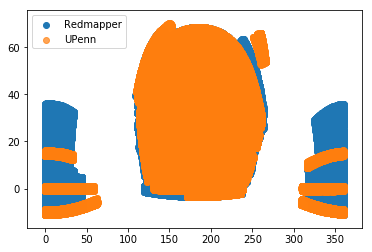

In [14]:
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(upenncat['RA'], upenncat['DEC'], alpha=0.7, label='UPenn')
ax.legend(loc='upper left')

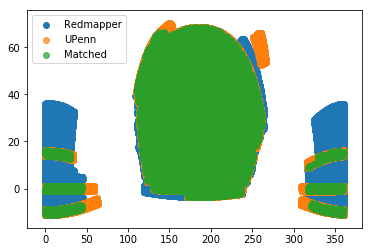

In [15]:
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(upenncat['RA'], upenncat['DEC'], alpha=0.7, label='UPenn')
ax.scatter(upenncat['RA'][idx[gd]], upenncat['DEC'][idx[gd]], alpha=0.7, label='Matched')
ax.legend(loc='upper left')

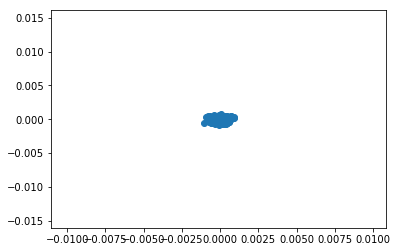

In [16]:
plt.scatter(rmcat['RA'][gd] - upenncat['RA'][idx[gd]], rmcat['DEC'][gd] - upenncat['DEC'][idx[gd]])

In [17]:
(rmcat['RA'] - upenncat[idx]['RA']) * 3600

array([   1.21145462,   88.37902542,  -46.95989881, ..., -295.143147  ,
        -84.02245114, -111.28514995])

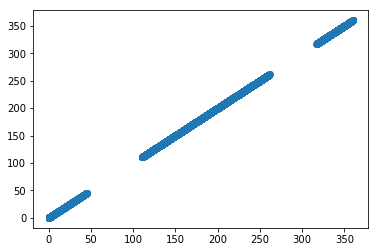

In [19]:
fig, ax = plt.subplots()
plt.scatter(rmcat['RA'][gd], upenncat['RA'][idx[gd]])

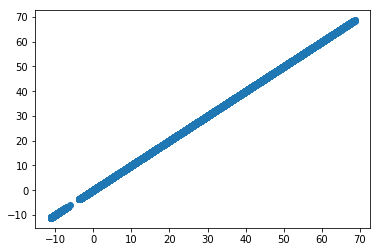

In [20]:
fig, ax = plt.subplots()
plt.scatter(rmcat['DEC'][gd], upenncat['DEC'][idx[gd]])

[ 1.01699777 -0.13972866]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


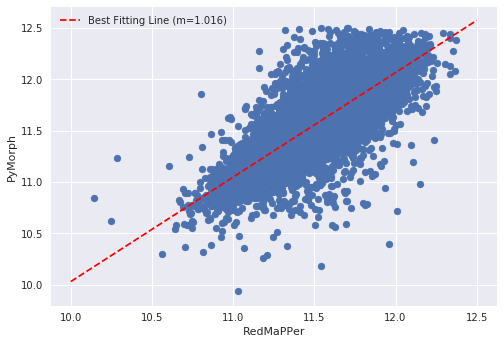

In [15]:
import seaborn as sns
fig, ax = plt.subplots()
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]])
qq = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]], 1)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*qq[0]+qq[1], 'r--', label='Best Fitting Line (m=1.016)')
print(qq)
plt.xlabel('RedMaPPer')
plt.ylabel('PyMorph')
plt.legend()

In [17]:
qq, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]], 1, cov=True)
error = np.sqrt(np.diag(cov))
print(error)

[ 0.00454551  0.05238261]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


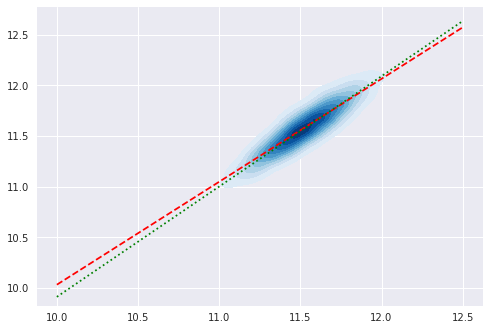

In [33]:
sns.kdeplot(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]],
            cmap="Blues", shade=True, shade_lowest=False)
plt.plot(xx, xx*qq[0]+qq[1], 'r--', label='Best Fitting Line (m=1.016)')
plt.plot(xx, xx*1.09-0.99, 'g:', label='Best Fitting Line (m=adjusted by eye)')

[ 0.94430402  0.65816547]
[ 0.00454419  0.05236735]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


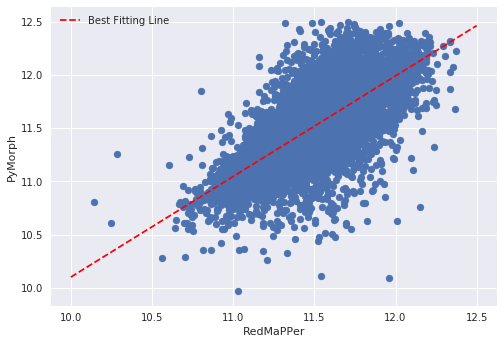

In [32]:
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Pymorph'][idx[gd]])
mm, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Pymorph'][idx[gd]], 1, cov=True)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*mm[0]+mm[1], 'r--', label='Best Fitting Line')
print(mm)
plt.xlabel('RedMaPPer')
plt.ylabel('PyMorph')
plt.legend()
error = np.sqrt(np.diag(cov))
print(error)

[ 0.94430402  0.65816547]
[ 0.00394692  0.04548441]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


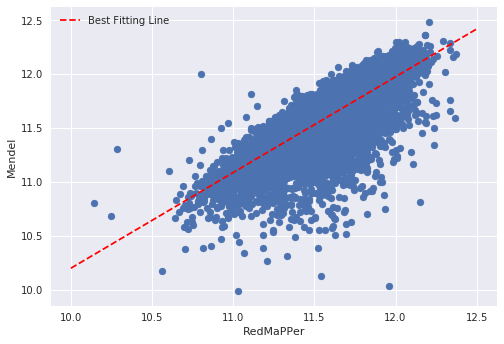

In [34]:
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Mendel'][idx[gd]])
pp, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Mendel'][idx[gd]], 1, cov=True)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*pp[0]+pp[1], 'r--', label='Best Fitting Line')
print(mm)
plt.xlabel('RedMaPPer')
plt.ylabel('Mendel')
plt.legend()
error = np.sqrt(np.diag(cov))
print(error)

[ 0.94430402  0.65816547]
[ 0.00383081  0.04414637]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


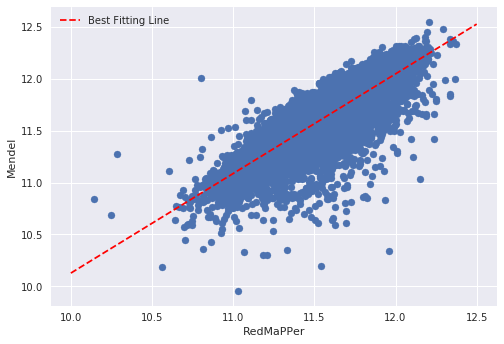

In [35]:
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Mendel'][idx[gd]])
tt, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Mendel'][idx[gd]], 1, cov=True)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*tt[0]+tt[1], 'r--', label='Best Fitting Line')
print(mm)
plt.xlabel('RedMaPPer')
plt.ylabel('Mendel')
plt.legend()
error = np.sqrt(np.diag(cov))
print(error)